In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors

## 1. Define the Lattice and Basis

Triangular lattice vectors:
- $\mathbf{a}_1 = (1, 0)$
- $\mathbf{a}_2 = (0.5, \sqrt{3}/2)$

In [3]:
# Lattice vectors
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, np.sqrt(3)/2])

# Basis atoms in fractional coordinates
atoms = [
    {"pos_frac": np.array([0.5, 0.5]), "radius": 0.3, "eps": 12.0, "label": "Atom 1 (ε=12)"},
    {"pos_frac": np.array([0.5, 0.25]), "radius": 0.3, "eps": 6.0, "label": "Atom 2 (ε=6)"},
]

eps_bg = 1.0  # Background epsilon (air)

def frac_to_cart(frac_pos, a1, a2):
    """Convert fractional to Cartesian coordinates."""
    return frac_pos[0] * a1 + frac_pos[1] * a2

# Compute Cartesian positions
for atom in atoms:
    atom["pos_cart"] = frac_to_cart(atom["pos_frac"], a1, a2)
    # Radius in Cartesian: r/a * |a1| (assuming a1 defines the lattice constant)
    atom["radius_cart"] = atom["radius"] * np.linalg.norm(a1)

print("Lattice vectors:")
print(f"  a1 = {a1}")
print(f"  a2 = {a2}")
print(f"\nBasis atoms:")
for i, atom in enumerate(atoms):
    print(f"  {atom['label']}:")
    print(f"    Fractional: {atom['pos_frac']}")
    print(f"    Cartesian:  {atom['pos_cart']}")
    print(f"    Radius:     {atom['radius_cart']:.4f}")

Lattice vectors:
  a1 = [1. 0.]
  a2 = [0.5       0.8660254]

Basis atoms:
  Atom 1 (ε=12):
    Fractional: [0.5 0.5]
    Cartesian:  [0.75      0.4330127]
    Radius:     0.3000
  Atom 2 (ε=6):
    Fractional: [0.5  0.25]
    Cartesian:  [0.625      0.21650635]
    Radius:     0.3000


## 2. Plot Lattice + Basis Structure

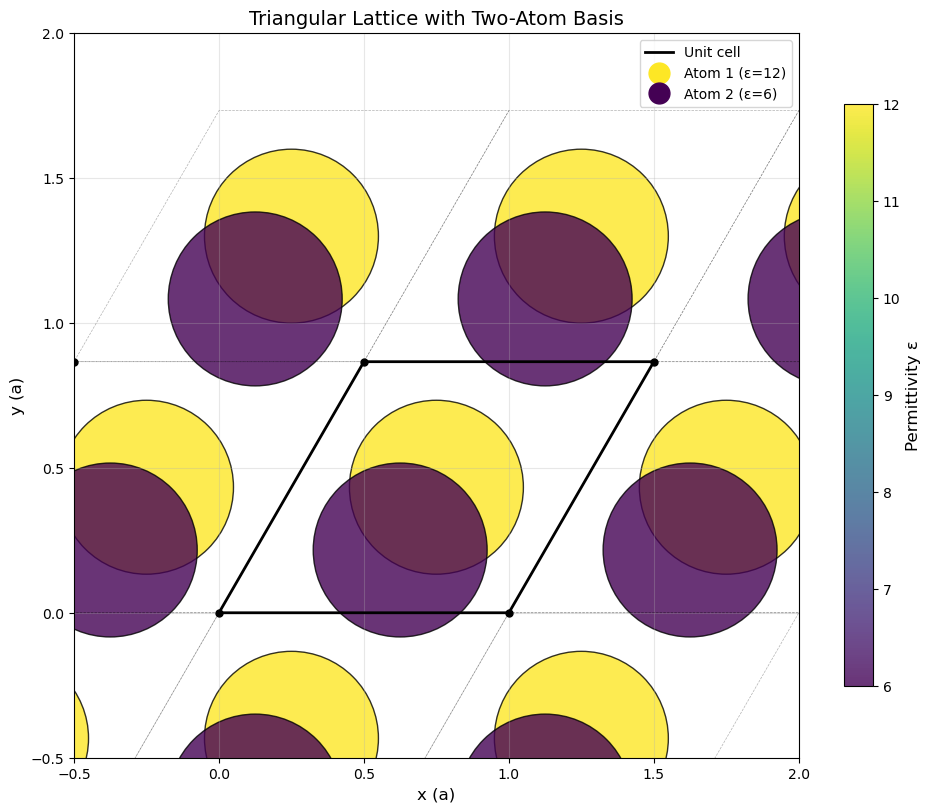

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot unit cell
origin = np.array([0.0, 0.0])
cell_corners = np.array([origin, a1, a1 + a2, a2, origin])
ax.plot(cell_corners[:, 0], cell_corners[:, 1], 'k-', linewidth=2, label='Unit cell')

# Plot multiple unit cells for context (3x3 grid)
for i in range(-1, 2):
    for j in range(-1, 2):
        offset = i * a1 + j * a2
        shifted_corners = cell_corners + offset
        ax.plot(shifted_corners[:, 0], shifted_corners[:, 1], 'k--', alpha=0.3, linewidth=0.5)

# Color map for epsilon values
eps_values = [atom["eps"] for atom in atoms]
norm = mcolors.Normalize(vmin=min(eps_values), vmax=max(eps_values))
cmap = plt.cm.viridis

# Plot atoms in multiple unit cells
patches = []
colors = []
for i in range(-1, 2):
    for j in range(-1, 2):
        offset = i * a1 + j * a2
        for atom in atoms:
            pos = atom["pos_cart"] + offset
            circle = Circle(pos, atom["radius_cart"])
            patches.append(circle)
            colors.append(atom["eps"])

collection = PatchCollection(patches, cmap=cmap, norm=norm, alpha=0.8, edgecolor='black')
collection.set_array(np.array(colors))
ax.add_collection(collection)

# Add colorbar
cbar = plt.colorbar(collection, ax=ax, shrink=0.6)
cbar.set_label('Permittivity ε', fontsize=12)

# Mark lattice points
for i in range(-1, 2):
    for j in range(-1, 2):
        point = i * a1 + j * a2
        ax.plot(point[0], point[1], 'ko', markersize=5)

# Add legend for atoms
for atom in atoms:
    ax.plot([], [], 'o', color=cmap(norm(atom["eps"])), markersize=15, 
            label=atom["label"])

ax.set_xlim(-0.5, 2.0)
ax.set_ylim(-0.5, 2.0)
ax.set_aspect('equal')
ax.set_xlabel('x (a)', fontsize=12)
ax.set_ylabel('y (a)', fontsize=12)
ax.set_title('Triangular Lattice with Two-Atom Basis', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Load and Visualize Smoothed ε(r) from blaze

Load the epsilon CSV exported by blaze-cli with `--export-epsilon`.

In [5]:
# Load epsilon data from blaze export
eps_csv_path = "/tmp/two_atom_epsilon.csv"
eps_df = pd.read_csv(eps_csv_path)

print(f"Loaded {len(eps_df)} grid points")
print(f"Columns: {list(eps_df.columns)}")
print(f"\nEpsilon range (smoothed): [{eps_df['eps_smoothed'].min():.3f}, {eps_df['eps_smoothed'].max():.3f}]")
print(f"Epsilon range (raw):      [{eps_df['eps_raw'].min():.3f}, {eps_df['eps_raw'].max():.3f}]")
eps_df.head()

Loaded 4096 grid points
Columns: ['ix', 'iy', 'frac_x', 'frac_y', 'eps_smoothed', 'inv_eps_smoothed', 'eps_raw', 'inv_eps_raw']

Epsilon range (smoothed): [1.000, 12.000]
Epsilon range (raw):      [1.000, 12.000]


,ix,iy,frac_x,frac_y,eps_smoothed,inv_eps_smoothed,eps_raw,inv_eps_raw
0,0,0,0.007812,0.007812,1.0,1.0,1.0,1.0
1,1,0,0.023438,0.007812,1.0,1.0,1.0,1.0
2,2,0,0.039062,0.007812,1.0,1.0,1.0,1.0
3,3,0,0.054688,0.007812,1.0,1.0,1.0,1.0
4,4,0,0.070312,0.007812,1.0,1.0,1.0,1.0


In [6]:
# Reshape to 2D grid
nx = eps_df['ix'].max() + 1
ny = eps_df['iy'].max() + 1
print(f"Grid size: {nx} x {ny}")

# Sort by iy, ix to get proper row-major ordering
eps_df_sorted = eps_df.sort_values(['iy', 'ix'])

eps_smoothed = eps_df_sorted['eps_smoothed'].values.reshape(ny, nx)
eps_raw = eps_df_sorted['eps_raw'].values.reshape(ny, nx)

# Get fractional coordinate grid for plotting
frac_x = eps_df_sorted['frac_x'].values.reshape(ny, nx)
frac_y = eps_df_sorted['frac_y'].values.reshape(ny, nx)

Grid size: 64 x 64


In [7]:
def frac_grid_to_cartesian(frac_x, frac_y, a1, a2):
    """Convert fractional coordinate grids to Cartesian."""
    cart_x = frac_x * a1[0] + frac_y * a2[0]
    cart_y = frac_x * a1[1] + frac_y * a2[1]
    return cart_x, cart_y

cart_x, cart_y = frac_grid_to_cartesian(frac_x, frac_y, a1, a2)

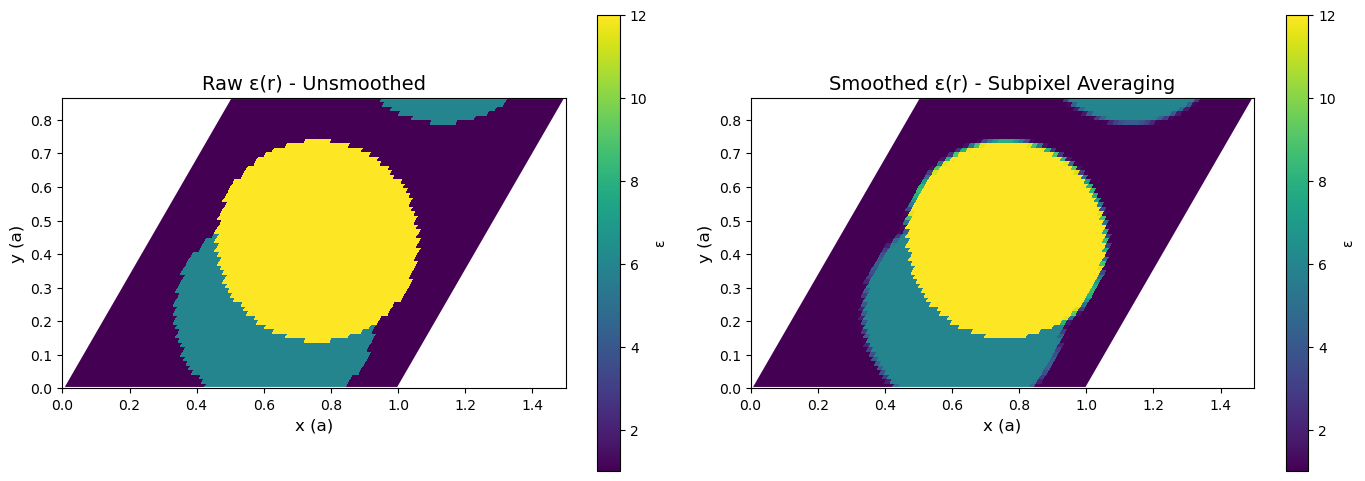

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Common colormap settings
vmin = 1.0
vmax = 12.0
cmap = 'viridis'

# Left: Raw (unsmoothed) epsilon
ax = axes[0]
im0 = ax.pcolormesh(cart_x, cart_y, eps_raw, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax.set_aspect('equal')
ax.set_xlabel('x (a)', fontsize=12)
ax.set_ylabel('y (a)', fontsize=12)
ax.set_title('Raw ε(r) - Unsmoothed', fontsize=14)
plt.colorbar(im0, ax=ax, shrink=0.8, label='ε')

# Overlay unit cell outline
cell_corners = np.array([[0, 0], a1, a1 + a2, a2, [0, 0]])
ax.plot(cell_corners[:, 0], cell_corners[:, 1], 'w-', linewidth=2)

# Right: Smoothed epsilon  
ax = axes[1]
im1 = ax.pcolormesh(cart_x, cart_y, eps_smoothed, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax.set_aspect('equal')
ax.set_xlabel('x (a)', fontsize=12)
ax.set_ylabel('y (a)', fontsize=12)
ax.set_title('Smoothed ε(r) - Subpixel Averaging', fontsize=14)
plt.colorbar(im1, ax=ax, shrink=0.8, label='ε')

# Overlay unit cell outline
ax.plot(cell_corners[:, 0], cell_corners[:, 1], 'w-', linewidth=2)

plt.tight_layout()
plt.show()

## 4. Cross-section Analysis

Plot ε along a line through both atoms to verify their epsilon values.

Cross-section at frac_x = 0.4922 (column 31)


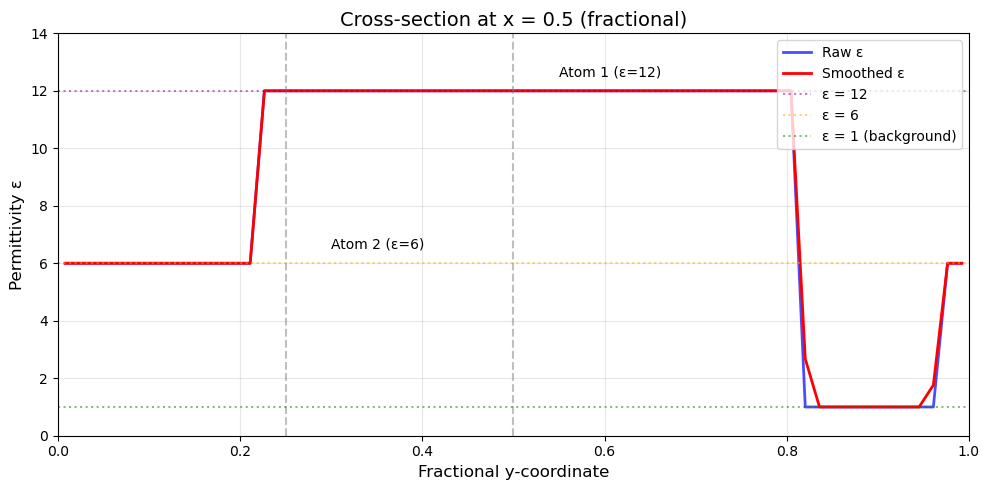

In [9]:
# Cross-section through x = 0.5 (fractional) which passes through both atoms
# Find the column closest to frac_x = 0.5
x_target = 0.5
col_idx = np.argmin(np.abs(frac_x[0, :] - x_target))
print(f"Cross-section at frac_x = {frac_x[0, col_idx]:.4f} (column {col_idx})")

eps_slice_smoothed = eps_smoothed[:, col_idx]
eps_slice_raw = eps_raw[:, col_idx]
y_coords = frac_y[:, col_idx]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_coords, eps_slice_raw, 'b-', linewidth=2, label='Raw ε', alpha=0.7)
ax.plot(y_coords, eps_slice_smoothed, 'r-', linewidth=2, label='Smoothed ε')

# Mark atom positions
for atom in atoms:
    ax.axvline(atom['pos_frac'][1], color='gray', linestyle='--', alpha=0.5)
    ax.annotate(atom['label'], xy=(atom['pos_frac'][1], atom['eps']), 
                xytext=(atom['pos_frac'][1] + 0.05, atom['eps'] + 0.5),
                fontsize=10, ha='left')

ax.axhline(12.0, color='purple', linestyle=':', alpha=0.5, label='ε = 12')
ax.axhline(6.0, color='orange', linestyle=':', alpha=0.5, label='ε = 6')
ax.axhline(1.0, color='green', linestyle=':', alpha=0.5, label='ε = 1 (background)')

ax.set_xlabel('Fractional y-coordinate', fontsize=12)
ax.set_ylabel('Permittivity ε', fontsize=12)
ax.set_title(f'Cross-section at x = {x_target} (fractional)', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 14)
plt.tight_layout()
plt.show()

## 5. Histogram of Epsilon Values

Check the distribution to verify both materials are present.

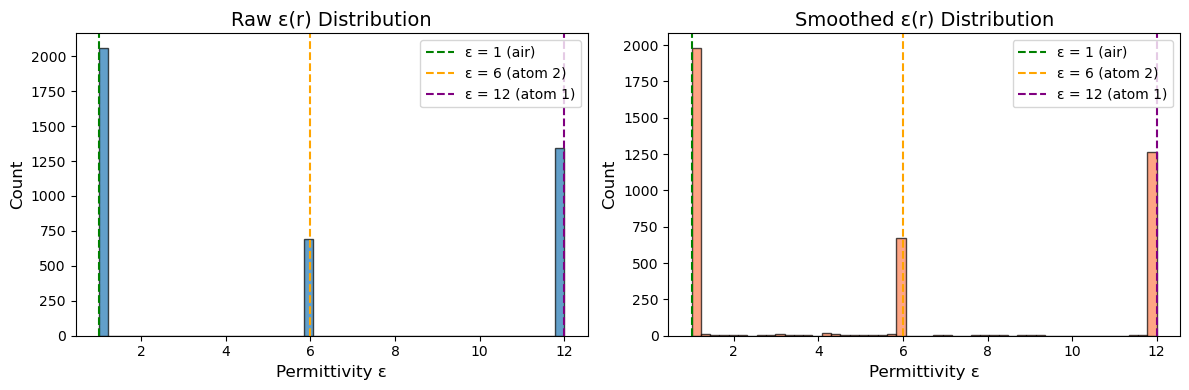


Raw epsilon statistics:
  Unique values: [ 1.  6. 12.]

Smoothed epsilon statistics:
  Min: 1.0000
  Max: 12.0000
  Mean: 5.3913


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Raw epsilon histogram
ax = axes[0]
ax.hist(eps_raw.flatten(), bins=50, edgecolor='black', alpha=0.7)
ax.axvline(1.0, color='green', linestyle='--', label='ε = 1 (air)')
ax.axvline(6.0, color='orange', linestyle='--', label='ε = 6 (atom 2)')
ax.axvline(12.0, color='purple', linestyle='--', label='ε = 12 (atom 1)')
ax.set_xlabel('Permittivity ε', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Raw ε(r) Distribution', fontsize=14)
ax.legend()

# Smoothed epsilon histogram
ax = axes[1]
ax.hist(eps_smoothed.flatten(), bins=50, edgecolor='black', alpha=0.7, color='coral')
ax.axvline(1.0, color='green', linestyle='--', label='ε = 1 (air)')
ax.axvline(6.0, color='orange', linestyle='--', label='ε = 6 (atom 2)')
ax.axvline(12.0, color='purple', linestyle='--', label='ε = 12 (atom 1)')
ax.set_xlabel('Permittivity ε', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Smoothed ε(r) Distribution', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

# Statistics
print("\nRaw epsilon statistics:")
unique_raw = np.unique(eps_raw)
print(f"  Unique values: {unique_raw}")

print("\nSmoothed epsilon statistics:")
print(f"  Min: {eps_smoothed.min():.4f}")
print(f"  Max: {eps_smoothed.max():.4f}")
print(f"  Mean: {eps_smoothed.mean():.4f}")